

<p><img height="80px" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/UPM/Escudo/EscUpm.jpg" align="left" hspace="0px" vspace="0px"></p>

**Course "Artificial Neural Networks and Deep Learning" - Universidad Politécnica de Madrid (UPM)**

# **Deep Q-Learning for Lunar Lander**

This notebook includes an implementation of the Deep Q-learning (DQN) algorithm for the lunar lander problem (see [OpenAI's Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/)).

**Componentes del grupo:**
- Jose Antonio Nicolás Navarro: joseantonio.nicolas@alumnos.upm.es
- Jose Cerezo Egea: jose.cerezo@alumnos.upm.es
- Arantzazu Ramos del Valle: arantzazu.ramosd@lumnos.upm.es 



## Introducción

En este trabajo se busca resolver de la forma óptima el *lunar lander problem* mediante Deep Q-learning (DQL). El *lunar lander problem* consiste en controlar los motores de una sonda lunar para que aterrice correctamente en una plataforma de aterrizaje. 

En este trabajo, se utilizará una versión simplificada de este problema en la que el estado de la sonda quedará determinada por 8 dimensiones; 6 variables continuas y 2 discretas. Estas variables de estado son la posición (3 dimensiones: coordenadas en el plano y ángulo), velocidad (3 dimensiones) y si cada una de las patas está en contacto con el suelo. Para cambiar de estado, habrá 4 posibles acciones; no hacer nada o activar uno de los tres motores. El combustible es infinito por lo que no hay límite de cuanto puede estar la sonda volando.

La plataforma de aterrizaje se encuentra siempre en las coordenadas (0,0). En función de las acciones realizadas por la sonda y de si consigue el objetivo de aterrizar exitosamente en la plataforma se obtendrán unas recompensas, positivas o negativas (que se detallarán más adelante). El episodio finaliza cuando la sonda se choca o aterriza. Existe la posibilidad de que aterrice fuera del la plataforma de aterrizaje.






##Libraries

In [ ]:
!pip3 install box2d-py
!pip3 install gym[Box_2D]
import gym

In [ ]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import random

## Hyperparameters

In [ ]:
GAMMA = 0.99
MEMORY_SIZE = 1000000
LEARNING_RATE = 0.0001
BATCH_SIZE = 64
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.1
EXPLORATION_DECAY = 0.995
NUMBER_OF_EPISODES = 700
#MAX_GOAL_REACHED = 10

## Class ReplayMemory

Memory of transitions for experience replay.

In [ ]:
class ReplayMemory:

    def __init__(self,number_of_observations):
        # Create replay memory
        self.states = np.zeros((MEMORY_SIZE, number_of_observations))
        self.states_next = np.zeros((MEMORY_SIZE, number_of_observations))
        self.actions = np.zeros(MEMORY_SIZE, dtype=np.int32)
        self.rewards = np.zeros(MEMORY_SIZE)
        self.terminal_states = np.zeros(MEMORY_SIZE, dtype=bool)
        self.current_size=0

    def store_transition(self, state, action, reward, state_next, terminal_state):
        # Store a transition (s,a,r,s') in the replay memory
        i = self.current_size
        self.states[i] = state
        self.states_next[i] = state_next
        self.actions[i] = action
        self.rewards[i] = reward
        self.terminal_states[i] = terminal_state
        self.current_size = i + 1

    def sample_memory(self, batch_size):
        # Generate a sample of transitions from the replay memory
        batch = np.random.choice(self.current_size, batch_size)
        states = self.states[batch]
        states_next = self.states_next[batch]
        rewards = self.rewards[batch]
        actions = self.actions[batch]   
        terminal_states = self.terminal_states[batch]  
        return states, actions, rewards, states_next, terminal_states

## Class DQN

Reinforcement learning agent with a Deep Q-Network.

En esta parte del código se implementa la mejora de la *target network*, que como se puede observar, tiene la misma arquitectura que la *policy network* y solamente va a diferenciarse en la actualización de los pesos. Para ello, hemos añadido el método *update_target_model()*. Esto, lo realizamos una vez por episodio, pues consideramos que no es necesaria una constante actualización de los pesos puesto que estamos tratando con un problema diferente.

En el método *learn()* se predicen los siguientes mejores estados empleando la *target_network*. 

In [ ]:
class DQN:

    def __init__(self, number_of_observations, number_of_actions):
        # Initialize variables and create neural model
        self.exploration_rate = EXPLORATION_MAX
        self.number_of_actions = number_of_actions
        self.number_of_observations = number_of_observations
        self.scores = []
        self.memory = ReplayMemory(number_of_observations)

        # Policy network
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.Dense(128, input_shape=(number_of_observations,), activation="relu",kernel_initializer="he_normal"))
        self.model.add(keras.layers.Dense(128, activation="relu",kernel_initializer="he_normal"))
        self.model.add(keras.layers.Dense(number_of_actions, activation="linear"))
        self.model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

        # Target network
        self.target_model = keras.models.Sequential()
        self.target_model.add(keras.layers.Dense(128, input_shape=(number_of_observations,), activation="relu",kernel_initializer="he_normal"))
        self.target_model.add(keras.layers.Dense(128, activation="relu",kernel_initializer="he_normal"))
        self.target_model.add(keras.layers.Dense(number_of_actions, activation="linear"))
        self.target_model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))
        self.update_target_model()

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, terminal_state):
        # Store a tuple (s, a, r, s') for experience replay
        state = np.reshape(state, [1, self.number_of_observations])
        next_state = np.reshape(next_state, [1, self.number_of_observations])
        self.memory.store_transition(state, action, reward, next_state, terminal_state)

    def select(self, state):
        # Generate an action for a given state using epsilon-greedy policy
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.number_of_actions)
        else:
            state = np.reshape(state, [1, self.number_of_observations])
            q_values = self.model.predict(state)
            return np.argmax(q_values[0])

    def learn(self):
        # Learn the value Q using a sample of examples from the replay memory
        if self.memory.current_size < BATCH_SIZE: return

        states, actions, rewards, next_states, terminal_states = self.memory.sample_memory(BATCH_SIZE)

        q_targets = self.model.predict(states)
        q_next_states = self.target_model.predict(next_states)

        for i in range(BATCH_SIZE):
             if (terminal_states[i]):
                  q_targets[i][actions[i]] = rewards[i]
             else:
                  q_targets[i][actions[i]] = rewards[i] + GAMMA * np.max(q_next_states[i])    

        self.model.train_on_batch(states, q_targets)

    def add_score(self, score):
       # Add the obtained score in a list to be presented later
        self.scores.append(score)

    def display_scores_graphically(self):
        # Display the obtained scores graphically
        plt.plot(self.scores)
        plt.xlabel("Episode")
        plt.ylabel("Score")            

## Environment Lunar Lander

Lunar Lander simulator from [Open Ai Gym](https://gym.openai.com/envs/LunarLander-v2/):

<p><img height="200px" src="https://gym.openai.com/videos/2019-10-21--mqt8Qj1mwo/LunarLander-v2/poster.jpg" align="center" vspace="20px"</p>



State vector:

- state[0]: coordenda horizontal 
- state[1]: coordenada vertical 
- state[2]: velocidad horizontal 
- state[3]: velocidad vertical 
- state[4]: ángulo
- state[5]: velocidad angular 
- state[6]: 1 si la primera pata está en contacto, sino 0
- state[7]: 1 si la segunda pata está en contacto, sino 0

Actions:
- 0 (no hacer nada)
- 1 (activar el motor orientado a la izquierda)
- 2 (activar el motor principal)
- 3 (activar el motor orientado a la derecha)

Recompensas:
- -100 (sonda se estrella)
- +100 (sonda aterriza)
- +10 (cada pata en contacto con el suelo)
- -0.3 (cada fotograma con el motor principal activo)
- -0.03 (cada fotograma con un motor lateral activo)
- 200 (resolverlo)


In [ ]:
def create_environment():
    # Create simulated environment
    environment = gym.make("LunarLander-v2")
    number_of_observations = environment.observation_space.shape[0]
    number_of_actions = environment.action_space.n
    return environment, number_of_observations, number_of_actions

## Main program




Se ha eliminado la segunda condición del bucle exterior porque se quería ver que la nave podía aterrizar de forma exitosa repetidas veces una vez el modelo aprendiera la mejor tabla de transiciones Q.

Además, hemos añadido una variable 'rewards' que acumula todas las recompensas obtenidas en ese episodio. Esto es diferente del problema de cart-pole porque en este problema la recompensa no está relacionada con el número de iteraciones que se mantiene el palo en equilibrio, sino con cómo la nave interactúa con el entorno.

La última de las modicaciones es la de añadir la red objetivo (*target network*) vista en las clases de teoría, que sirve para reducir la variabilidad de los valores objetivo. Por tanto, en el código esto se traduce como la actualización de los pesos del modelo objetivo a través de la red de política (*policy network*).

Episode   1: Rewards -64.25667358843893 (exploration rate: 0.99, transitions: 71)
Episode   2: Rewards -161.6078557083591 (exploration rate: 0.99, transitions: 203)
Episode   3: Rewards 5.977668105675193 (exploration rate: 0.99, transitions: 308)
Episode   4: Rewards -157.0950329574294 (exploration rate: 0.98, transitions: 425)
Episode   5: Rewards -347.53507763376365 (exploration rate: 0.98, transitions: 539)
Episode   6: Rewards -250.84273865477735 (exploration rate: 0.97, transitions: 628)
Episode   7: Rewards -128.6358968298706 (exploration rate: 0.97, transitions: 714)
Episode   8: Rewards -162.3704634659208 (exploration rate: 0.96, transitions: 792)
Episode   9: Rewards -83.63465250038747 (exploration rate: 0.96, transitions: 903)
Episode  10: Rewards 21.997476096068198 (exploration rate: 0.95, transitions: 1026)
Episode  11: Rewards -158.41721879693438 (exploration rate: 0.95, transitions: 1106)
Episode  12: Rewards -320.91219468959514 (exploration rate: 0.94, transitions: 1208)

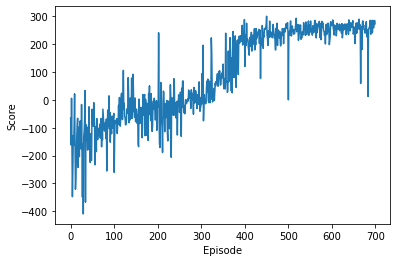

In [ ]:
environment, number_of_observations, number_of_actions = create_environment()
agent = DQN(number_of_observations, number_of_actions)
episode = 0
n_goal_reached = 0
start_time = time.perf_counter()


while (episode < NUMBER_OF_EPISODES):#and not (n_goal_reached == MAX_GOAL_REACHED):
    episode += 1
    rewards = 0
    terminal_state = False
    state = environment.reset()
    
    while not terminal_state:      
        # Select an action for the current state
        action = agent.select(state)

        # Execute the action on the environment
        state_next, reward, terminal_state, info = environment.step(action)
        rewards += reward

        # Store in memory the transition (s,a,r,s') 
        agent.remember(state, action, reward, state_next, terminal_state)

        # Learn using a batch of experience stored in memory
        agent.learn()
        state = state_next

    # We update the weights of the target network given the model
    agent.update_target_model()

    # We update the exploration rate every episode
    agent.exploration_rate *= EXPLORATION_DECAY
    agent.exploration_rate = max(EXPLORATION_MIN, agent.exploration_rate)

    agent.add_score(rewards)
    # If the reward is equal 100, then the spaceship has landed successfully
    if reward == 100: 
      n_goal_reached += 1
      print("Objetivo alcanzado")
    print("Episode {0:>3}: ".format(episode), end = '')
    print("Rewards {0:>3} ".format(rewards), end = '') 
    print("(exploration rate: %.2f, " % agent.exploration_rate, end = '')
    print("transitions: " + str(agent.memory.current_size) + ")") 

print("Number of times the lander finished successfully: " + str(n_goal_reached))
print("Time:", round((time.perf_counter() - start_time)/60), "minutes")

agent.display_scores_graphically()

Se puede observar como, a medida que avanzan lo episodios, el ratio de exploración va disminuyendo. Por tanto, en los primeros episodios, se escogera la mayor parte de acciones de forma aleatoria, favoreciendo la exploración de soluciones. En los ultimos episodios, como el ratio de exploración es bajo, se favore la explotación de aquellas soluciones que son mejores.

En los primeros episodios, la forma en la que se eligen las acciones de la sonda es, en su mayor, parte aleatoria. Esto hace que la trayectoria difiera mucho de un episodio a otro y se obtengan recompensas finales muy distintas. A medida que avanzan los episodios, las soluciones que se obtienen son mejores, es decir, con una mayor recompensa final. Esto se debe a que las acciones se escogen según lo que ha obtenido mejores resultados previamente. Las recompensas máximas que se acercan a los 300 puntos y alcanzando el objetivo. Para los últimos episodios, casi siempre se obtienen resultados  cercanos a este y muy similares entre si, ya que no hay tanta aleatoriedad en la decisión de acciones.